# Train Diabetic Retinopathy Model

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

base_dir = '../data/'
train_dir = base_dir + 'small_train/'
validation_dir = base_dir + 'small_test/'
img_width = 540
img_height = 540
img_channel = 3

### Montando o modelo

In [2]:
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from keras.models import Model
from keras.optimizers import Adam

inputs = Input(shape=(img_height, img_width, img_channel))

X = Conv2D(32, (3, 3), activation='relu')(inputs)
X = Conv2D(64, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2))(X)

X = Conv2D(96, (3, 3), activation='relu')(X)
X = Conv2D(128, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2))(X)

X = Conv2D(160, (3, 3), activation='relu')(X)
X = Conv2D(192, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2))(X)

X = Conv2D(224, (3, 3), activation='relu')(X)
X = Conv2D(256, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2))(X)

X = Conv2D(228, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2))(X)

X = Flatten()(X)
X = Dropout(0.1)(X)
X = Dense(320, activation='relu')(X)
X = Dense(352, activation='relu')(X)
outputs = Dense(5, activation='softmax')(X)

model = Model(inputs=inputs, outputs=outputs)
#adam = Adam(lr=0.000001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#adam = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#adam = Adam(lr=0.00002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#adam = Adam(lr=0.00005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-4, amsgrad=False)
adam = Adam(lr=0.00005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 540, 540, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 538, 538, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 536, 536, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 268, 268, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 266, 266, 96)      55392     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 264, 264, 128)     110720    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 132, 132, 128)     0         
__________

### Carregando Modelo Pré Treinado

Pule o código abaixo se desejar treinar o modelo do zero.

In [3]:
import os
from keras import models

#model_path = os.path.join('../models', 'diabetic_retinopathy_model.h5') 

#model = models.load_model(model_path)

### Processamento de dados

In [4]:
mean_0 = 104.183330781893
mean_1 = 106.9134984430727
mean_2 = 111.30260913923182

std_0 = 4.2141225097
std_1 = 4.49451983235
std_2 = 4.5237623716

def z_score(image):
    image = np.array(image)
    image[:,:,0] = np.subtract(image[:,:,0], [mean_0]) / std_0
    image[:,:,1] = np.subtract(image[:,:,1], [mean_1]) / std_1
    image[:,:,2] = np.subtract(image[:,:,2], [mean_2]) / std_2
    return image


In [5]:
from keras_preprocessing.image import ImageDataGenerator

#train_datagen = ImageDataGenerator(
#    rescale=1./255,
#    rotation_range=360,
#    zoom_range=[1 / 1.15, 1.15],
#    horizontal_flip=True,
#    vertical_flip=True)

#validation_datagen = ImageDataGenerator(
#    rescale=1./255)

train_datagen = ImageDataGenerator(
    preprocessing_function=z_score,
    rotation_range=360,
    zoom_range=[1 / 1.15, 1.15],
    horizontal_flip=True,
    vertical_flip=True)

validation_datagen = ImageDataGenerator(
    preprocessing_function=z_score)


In [6]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    shuffle=True,
    batch_size=25,
    class_mode='categorical')

Found 1000 images belonging to 5 classes.


In [7]:
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_width, img_height),
    shuffle=True,
    batch_size=25,
    class_mode='categorical')

Found 1000 images belonging to 5 classes.


In [8]:
#data = next(iter(train_generator))

# Check Class Weight

In [9]:
#import os
#
#len_0 = len(os.listdir(train_dir + '0'))
#len_1 = len(os.listdir(train_dir + '1'))
#len_2 = len(os.listdir(train_dir + '2'))
#len_3 = len(os.listdir(train_dir + '3'))
#len_4 = len(os.listdir(train_dir + '4'))
#
#len_tot = len_0 + len_1 + len_2 + len_3 + len_4
#
#w0 = len_0 * 1./ len_tot
#w1 = len_1 * 1./ len_tot
#w2 = len_2 * 1./ len_tot
#w3 = len_3 * 1./ len_tot
#w4 = len_4 * 1./ len_tot

#class_weight = {0: w0, 1: w1, 2: w2, 3: w3, 4: w4}
class_weight = {0: 0.46182373, 
                1: 1.33303985, 
                2: 0.62618633, 
                3: 3.90590631, 
                4: 4.31936937}

In [10]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, LearningRateScheduler
import time, math

# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.003
    drop = 0.1
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

lrate = LearningRateScheduler(step_decay)

earlystopper = EarlyStopping(patience=10, verbose=1)

model_path = os.path.join('../models', 'diabetic_retinopathy_model.h5') 

checkpointer = ModelCheckpoint(model_path, verbose=1, save_best_only=True)

tb = TensorBoard(log_dir='../logs/tb' + str(np.round(time.time(),0)), 
                 histogram_freq=0, batch_size=100,
                 write_graph=True)

callbacks_list = [earlystopper, checkpointer, tb]

http://localhost:6006 to Tensorboard

In [11]:
from keras import callbacks
from keras.callbacks import TensorBoard
import time

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size

history = model.fit_generator(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    epochs=200, 
    validation_data=validation_generator,
    validation_steps=STEP_SIZE_VALID,
    #class_weight=class_weight,
    callbacks=callbacks_list)


Epoch 1/200
40/40 [==============================] - 147s 4s/step - loss: 1.6222 - acc: 0.1890 - val_loss: 1.6118 - val_acc: 0.2250

Epoch 00001: val_loss improved from inf to 1.61184, saving model to ../models/diabetic_retinopathy_model.h5
Epoch 2/200
40/40 [==============================] - 130s 3s/step - loss: 1.6091 - acc: 0.2100 - val_loss: 1.5988 - val_acc: 0.2630

Epoch 00002: val_loss improved from 1.61184 to 1.59879, saving model to ../models/diabetic_retinopathy_model.h5
Epoch 3/200
40/40 [==============================] - 130s 3s/step - loss: 1.5984 - acc: 0.2310 - val_loss: 1.5856 - val_acc: 0.2450

Epoch 00003: val_loss improved from 1.59879 to 1.58563, saving model to ../models/diabetic_retinopathy_model.h5
Epoch 4/200
40/40 [==============================] - 130s 3s/step - loss: 1.5881 - acc: 0.2510 - val_loss: 1.5802 - val_acc: 0.2520

Epoch 00004: val_loss improved from 1.58563 to 1.58025, saving model to ../models/diabetic_retinopathy_model.h5
Epoch 5/200
40/40 [=====

Epoch 39/200
40/40 [==============================] - 130s 3s/step - loss: 1.2969 - acc: 0.4080 - val_loss: 1.4745 - val_acc: 0.3380

Epoch 00039: val_loss did not improve from 1.41055
Epoch 40/200
40/40 [==============================] - 130s 3s/step - loss: 1.2854 - acc: 0.4190 - val_loss: 1.4495 - val_acc: 0.3480

Epoch 00040: val_loss did not improve from 1.41055
Epoch 41/200
40/40 [==============================] - 130s 3s/step - loss: 1.2922 - acc: 0.4420 - val_loss: 1.4688 - val_acc: 0.3930

Epoch 00041: val_loss did not improve from 1.41055
Epoch 42/200
40/40 [==============================] - 130s 3s/step - loss: 1.2536 - acc: 0.4570 - val_loss: 1.3836 - val_acc: 0.3940

Epoch 00042: val_loss improved from 1.41055 to 1.38363, saving model to ../models/diabetic_retinopathy_model.h5
Epoch 43/200
40/40 [==============================] - 130s 3s/step - loss: 1.2264 - acc: 0.4630 - val_loss: 1.4107 - val_acc: 0.3770

Epoch 00043: val_loss did not improve from 1.38363
Epoch 44/200
4

# Plot Results

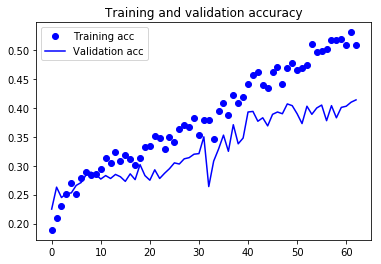

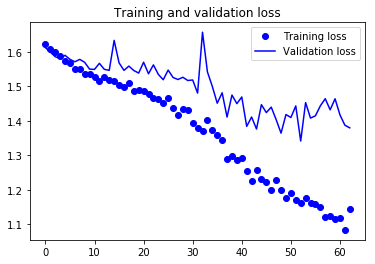

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Predict Test Base

In [13]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [14]:
batch_size = 1000

test_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_width, img_height),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical')

valid_X, valid_Y = next(test_generator)

Found 1000 images belonging to 5 classes.


In [15]:
#test_loss, test_acc = model.evaluate(next(test_generator))

In [16]:
pred_Y = model.predict(valid_X, batch_size = test_generator.n // test_generator.batch_size, verbose = True)

ValueError: Error when checking input: expected input_1 to have shape (540, 540, 3) but got array with shape (540, 540, 1)

In [ ]:
pred_Y

# Metrics

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
plt.matshow(confusion_matrix(np.argmax(valid_Y, -1), np.argmax(pred_Y,-1)))
print(classification_report(np.argmax(valid_Y, -1), 
                            np.argmax(pred_Y,-1)))

In [ ]:
confusion_matrix(np.argmax(valid_Y, -1), np.argmax(pred_Y,-1))

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, _ = roc_curve(np.argmax(valid_Y,-1)==0, pred_Y[:,0])
fig, ax1 = plt.subplots(1,1, figsize = (5, 5), dpi = 150)
ax1.plot(fpr, tpr, 'b.-', label = 'Model (AUC:%2.2f)' % roc_auc_score(np.argmax(valid_Y,-1)==0, pred_Y[:,0]))
ax1.plot(fpr, fpr, 'k-', label = 'Random Guessing')
ax1.legend(loc = 4)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate');
ax1.set_title('Lung Opacity ROC Curve')